# Exploration
Constant VPD experiment: ```/glade/campaign/univ/uwas0098/cnstVPDforPhoto_PI_SOM/tseries/```

Control experiment:
```/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/domain/proc/tseries/```

# Setup

In [1]:
import os
import numpy as np
import xarray as xr
import pickle as pkl

import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath

import cmocean.cm as cmo

## Figure settings

In [10]:
## Adjust dpi
mpl.rcParams['figure.dpi'] = 160

## Assign figure output format
# %config InlineBackend.figure_formats = ['pdf']
%config InlineBackend.figure_formats = ['png']

# Import data

In [12]:
## Constant VPD experiment
path_cstvpd = '/glade/campaign/univ/uwas0098/cnstVPDforPhoto_PI_SOM/tseries/'

varlist_cstvpd = []
for file in os.listdir(path_cstvpd):
    varlist_cstvpd.append(file.split('.')[4])
varlist_cstvpd = sorted(varlist_cstvpd)

In [34]:
## Control VPD experiment
basepath_ctlvpd = '/glade/campaign/cgd/tss/czarakas/CoupledPPE/'
ensemble = 'coupled'
domain = 'atm'

if ensemble == 'offline':
    ensemble_path = 'offline_simulations'
    refcase_id = 'OFFL0000_PI_v02'
elif ensemble == 'coupled':
    ensemble_path = 'coupled_simulations'
    refcase_id = 'COUP0000_PI_SOM'

if domain == 'atm':
    domain_suffix = '.cam.h0.'
elif domain == 'lnd':
    domain_suffix = '.clm2.h0.'

path_ctlvpd = basepath_ctlvpd+ensemble_path+'/'+refcase_id+'/'+domain+'/proc/tseries/'

varlist_ctlvpd = []
for file in os.listdir(path_ctlvpd):
    if file.split('.')[2] == 'h0':
        varlist_ctlvpd.append(file.split('.')[4])
varlist_ctlvpd = sorted(varlist_ctlvpd)

In [26]:
## Get the variables in common between the two experiments
set_cstvpd = set(varlist_cstvpd)
set_ctlvpd = set(varlist_ctlvpd)
varlist = sorted(list(set_cstvpd.intersection(set_ctlvpd)))
print(varlist)

In [36]:
var = 'TREFHT'
tref_ctl = xr.open_dataset(path_ctlvpd+'/'+refcase_id+domain_suffix+'timeseries.'+var+'.nc')

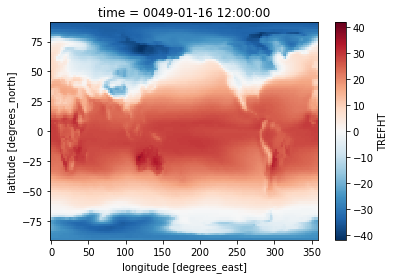

In [49]:
(tref_ctl['TREFHT'].isel(time=0)-273.15).plot()